# Building a multi-class PyTorch model

## 1. Import libraries


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
from torcheval.metrics.functional import multiclass_accuracy, multiclass_confusion_matrix

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from helper_functions import plot_decision_boundary, plot_loss_curves
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

## 2. Creating mutli-class classification data

### 2.1 Creating dataset of blobs

In [2]:
NUM_SAMPLES = 1000
NUM_CLASSES = 6
NUM_FEATURES = 2
RANDOM_SEED = 101

X_array, y_array = make_blobs(
    n_samples=NUM_SAMPLES,
    n_features=NUM_FEATURES,  # X features
    centers=NUM_CLASSES,  # y labels
    cluster_std=1.15,  # give the clusters a little shake up
    random_state=RANDOM_SEED,
)

print(f"X shape: {X_array.shape}")
print(f"y shape: {y_array.shape}")
print(f"\nFirst 5 samples od X:\n {X_array[:5]}")
print(f"\nFirst 5 samples od y:\n {y_array[:5]}")


X shape: (1000, 2)
y shape: (1000,)

First 5 samples od X:
 [[ 2.65914899 -3.58486549]
 [-1.94052332  0.41643395]
 [ 4.81106371  8.18923533]
 [-3.92851916  6.48208803]
 [ 5.99980821 -7.00815716]]

First 5 samples od y:
 [5 0 2 3 4]


### 2.2 Plot the dataset

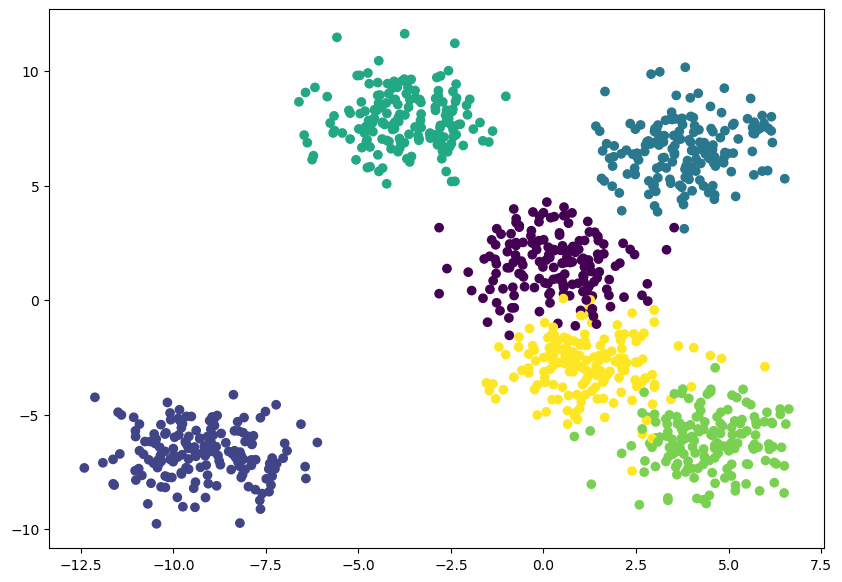

In [3]:
plt.figure(figsize=(10, 7))
plt.scatter(X_array[:, 0], X_array[:, 1], c=y_array);

### 2.3 Convert numpy array to torch tensor


In [4]:
X = torch.from_numpy(X_array).type(torch.float)
y = torch.from_numpy(y_array).type(torch.int64)

print(f"X dtype: {X.dtype}, X shape: {X.shape}")
print(f"y dtype: {y.dtype}, X shape: {y.shape}")

X dtype: torch.float32, X shape: torch.Size([1000, 2])
y dtype: torch.int64, X shape: torch.Size([1000])


### 2.4 Split data to train and test


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test : {X_test.shape}")
print(f"X_test : {y_test.shape}")

X_train: torch.Size([800, 2])
y_train: torch.Size([800])
X_test : torch.Size([200, 2])
X_test : torch.Size([200])


## 3. Building a multi-class classification model in PyTorch

### 3.1 Creating the model


In [6]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        :param input_features: Number of input features to the model.
        :type input_features: int
        :param output_features:Number of output features of the model
        :type output_features: int
        :param hidden_units: Number of hidden units between layers, defaults to 8
        :type hidden_units: int, optional
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [7]:
torch.manual_seed(RANDOM_SEED)

model = BlobModel(
    input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=10
)
summary(
    model,
    input_size=(2,),
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
BlobModel                                [2]                       [6]                       --                        True
├─Sequential: 1-1                        [2]                       [6]                       --                        True
│    └─Linear: 2-1                       [2]                       [10]                      30                        True
│    └─ReLU: 2-2                         [10]                      [10]                      --                        --
│    └─Linear: 2-3                       [10]                      [10]                      110                       True
│    └─ReLU: 2-4                         [10]                      [10]                      --                        --
│    └─Linear: 2-5                       [10]                      [6]                       66                        True
Total p

### 3.2. Creating a loss function and optimizer

In [8]:
loss_fn = nn.CrossEntropyLoss() # multi-class classification problem
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### 3.3 Getting prediction probabilities for a multi-class PyTorch model

In [9]:
model.eval()
with torch.inference_mode():
    untrained_logits = model(X_test)

print(f"untrained logits shape: {untrained_logits.shape}")
print(f"first 5 untrained logits:\n{untrained_logits[:5]}")

untrained_preds = torch.softmax(untrained_logits, dim=1)
print(f"\nuntrained preds shape: {untrained_preds.shape}")
print(f"first 5 untrained preds:\n{untrained_preds[:5]}")

untrained_classes = torch.argmax(untrained_preds, dim=1)
print(f"\nfirst 5 untrained_classes:\n{untrained_classes.squeeze()[:5]}")
print(f"\nfirst 5 labels:\n{y_test[:5]}")

untrained logits shape: torch.Size([200, 6])
first 5 untrained logits:
tensor([[ 0.1653, -0.0499,  0.1294, -0.3966, -0.1207, -0.2957],
        [ 0.1544, -0.1319,  0.0863, -0.2679,  0.0088, -0.1545],
        [ 0.7453, -0.1432,  0.2259, -0.6197, -0.3648, -0.5626],
        [-0.0103,  0.6017,  0.5811, -0.7983, -0.4977, -0.1987],
        [ 0.1924, -0.1646,  0.0973, -0.2590,  0.0374, -0.1767]])

untrained preds shape: torch.Size([200, 6])
first 5 untrained preds:
tensor([[0.2117, 0.1707, 0.2043, 0.1207, 0.1591, 0.1335],
        [0.2024, 0.1520, 0.1891, 0.1327, 0.1750, 0.1487],
        [0.3495, 0.1437, 0.2079, 0.0893, 0.1152, 0.0945],
        [0.1527, 0.2816, 0.2759, 0.0695, 0.0938, 0.1265],
        [0.2086, 0.1460, 0.1897, 0.1328, 0.1787, 0.1442]])

first 5 untrained_classes:
tensor([0, 0, 0, 1, 0])

first 5 labels:
tensor([2, 0, 4, 1, 0])


## 4. Train and test the model

### 4.1 training loop

In [10]:
def train(
    epochs: int,
    model: torch.nn.Module,
    X_train: torch.Tensor,
    X_test: torch.Tensor,
    y_train: torch.Tensor,
    y_test: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    print_step: int = 10,
) -> dict[str, list]:

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in tqdm(range(1, epochs + 1)):

        model.train()

        y_logits = model(X_train)
        loss = loss_fn(y_logits, y_train)
        train_loss = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        train_acc = multiclass_accuracy(y_pred, y_train)

        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test)
            test_loss = loss_fn(test_logits, y_test)

            test_pred = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
            test_acc = multiclass_accuracy(test_pred, y_test)

        if (epoch % print_step == 0) or (epoch == epochs):
            tqdm.write(
                f"Epoch: {epoch:3} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
            )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [11]:
results = train(
    epochs=500,
    model=model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    optimizer=optimizer,
    loss_fn=loss_fn,
    print_step=10,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch:  10 | train_loss: 1.3445 | train_acc: 0.6025 | test_loss: 1.4404 | test_acc: 0.4950
Epoch:  20 | train_loss: 1.0624 | train_acc: 0.7788 | test_loss: 1.1708 | test_acc: 0.6850
Epoch:  30 | train_loss: 0.7829 | train_acc: 0.7312 | test_loss: 0.8903 | test_acc: 0.6350
Epoch:  40 | train_loss: 0.6140 | train_acc: 0.7387 | test_loss: 0.7305 | test_acc: 0.6850
Epoch:  50 | train_loss: 0.5349 | train_acc: 0.7837 | test_loss: 0.6464 | test_acc: 0.7000
Epoch:  60 | train_loss: 0.4820 | train_acc: 0.8150 | test_loss: 0.5874 | test_acc: 0.7350
Epoch:  70 | train_loss: 0.4412 | train_acc: 0.8388 | test_loss: 0.5417 | test_acc: 0.7850
Epoch:  80 | train_loss: 0.4079 | train_acc: 0.8575 | test_loss: 0.5044 | test_acc: 0.8100
Epoch:  90 | train_loss: 0.3801 | train_acc: 0.8800 | test_loss: 0.4730 | test_acc: 0.8300
Epoch: 100 | train_loss: 0.3564 | train_acc: 0.8913 | test_loss: 0.4462 | test_acc: 0.8450
Epoch: 110 | train_loss: 0.3358 | train_acc: 0.9025 | test_loss: 0.4227 | test_acc: 0.8600

### 4.2 Plot loss and accuracy curves

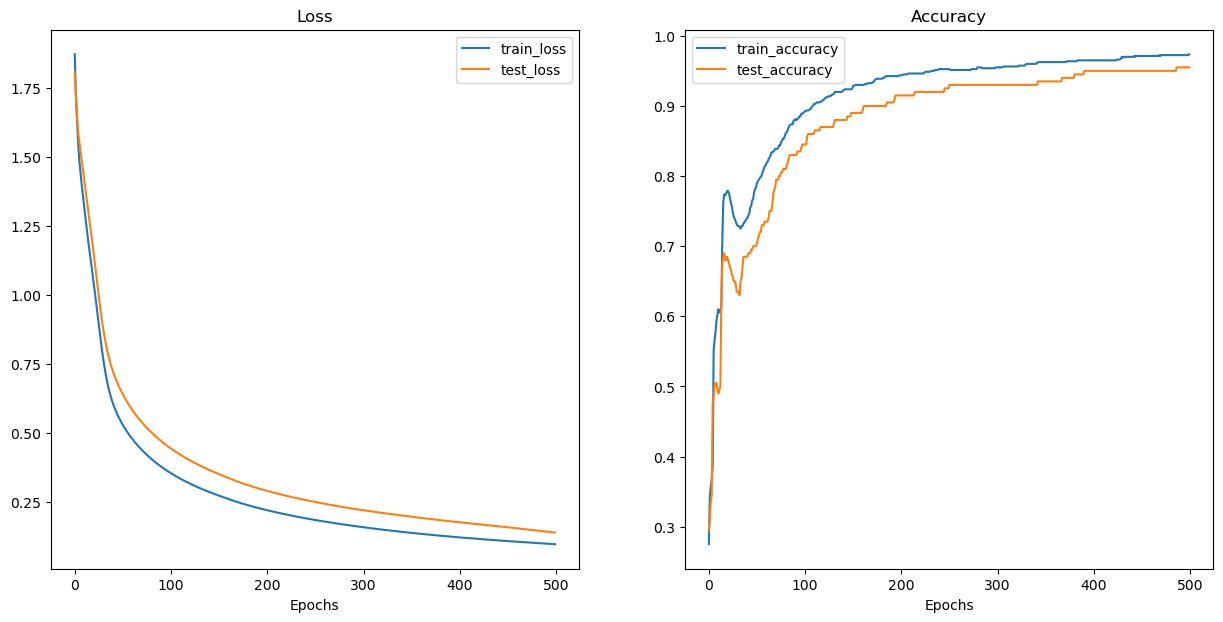

In [12]:
plot_loss_curves(results)

### 4.3 Plot the bounbaries

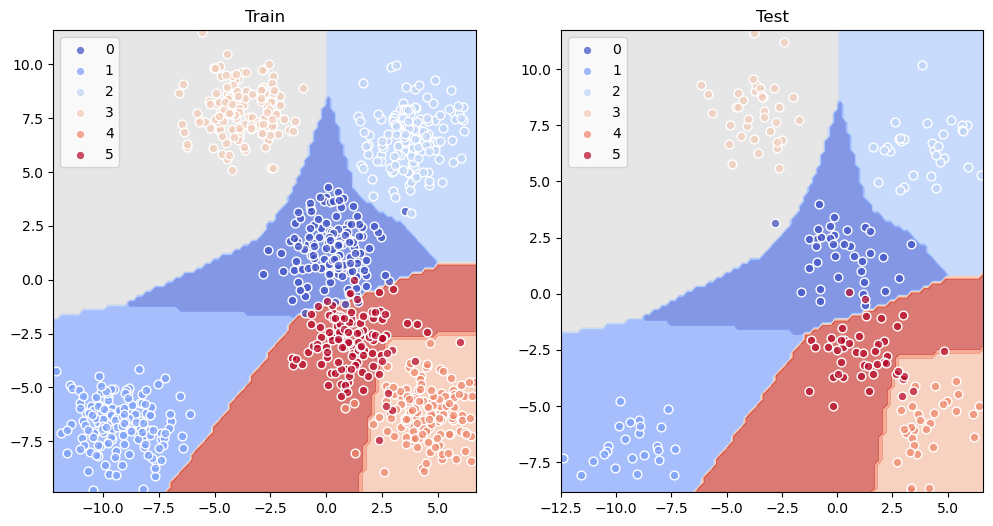

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

### 4.4 Making and evaluating predictions

In [14]:
model.eval()
with torch.inference_mode():
    y_pred_probs_test = model(X_test)
    y_pred_test = torch.argmax(y_pred_probs_test, dim=1)  # you can ignore softmax()
    test_loss = loss_fn(y_pred_probs_test, y_test)
    test_acc = multiclass_accuracy(y_pred_test, y_test)

print(f"First 10 predictions : {y_pred_test[:10]}")
print(f"First 10 labels      : {y_test[:10]}")
print(f"Test accuracy        : {test_acc:.3f}")

First 10 predictions : tensor([2, 0, 4, 1, 0, 5, 3, 2, 5, 1])
First 10 labels      : tensor([2, 0, 4, 1, 0, 5, 3, 2, 5, 1])
Test accuracy        : 0.955


### 4.5 Plot confusion matrix

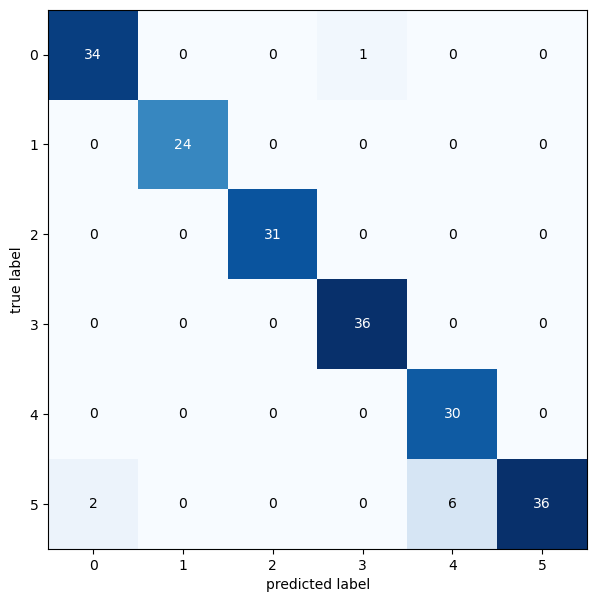

In [15]:
cm = multiclass_confusion_matrix(y_pred_test, y_test, NUM_CLASSES)
fig, ax = plot_confusion_matrix(cm.numpy(), figsize=(10, 7))